In [6]:
import kfold_model as kfm
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [7]:
# felix function
def outlier_detector_IQR(df,features,n_IQR, all_data = True):  

  dmin = {}
  dmax = {}
  lower_b = {}
  higher_b = {}
  count_min = {}
  count_max = {}

  for i in features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit, higher_limit = Q1 - n_IQR*IQR, Q3 +n_IQR*IQR

    lower_b[i] = [np.round(lower_limit,2)]   # min value per Log
    higher_b[i] = [np.round(higher_limit,2)] # max value per Log

    if df[i].min() < lower_limit:      
      dmin[i] = [np.round(df[i].min(),2)]
      count_min[i] = [len(df[i].loc[df[i] < lower_limit])]
    else:
      dmin[i] = '-----'
      count_min[i] = '-----'
    if df[i].max() > higher_limit:
      dmax[i] = [np.round(df[i].max(),2)]
      count_max[i] = [len(df[i].loc[df[i] > higher_limit])]
    else:
      dmax[i] = '-----'
      count_max[i] = '-----'

  lower = pd.DataFrame(lower_b).T.rename(columns={0:'Lower_Limit'})
  min = pd.DataFrame(dmin).T.rename(columns={0:'1st_Min_Outlier'})
  min_count = pd.DataFrame(count_min).T.rename(columns={0:'Total_Min_Out'})
  higher = pd.DataFrame(higher_b).T.rename(columns={0:'Higher_Limit'})  
  max = pd.DataFrame(dmax).T.rename(columns={0:'Last_Max_Outlier'})
  max_count = pd.DataFrame(count_max).T.rename(columns={0:'Total_Max_Out'})  

  return pd.concat([lower,min,min_count,higher,max,max_count],axis=1) 

In [8]:
# felix function
def outlier_replacer(df,column,min=None,max=None):  

  if min != None:
    min_idx = list(df.loc[df[column]<=min].index.values)
    df.at[min_idx,column] = min
  else:
    pass

  if max != None:
    max_idx = list(df.loc[df[column]>=max].index.values)
    df.at[max_idx,column] = max
  else:
    pass  

  return df

## preparing data for the model

In [70]:
# loding eda dataset
well_data_Softypo_ft = pd.read_csv('final_well_data_Softypo_ft.csv', index_col=0)
#well_data_Softypo_ft.describe()

In [10]:
# looking for outliers
#outlier_detector_IQR(well_data_Softypo_ft[well_data_Softypo_ft.dtypes[well_data_Softypo_ft.dtypes != 'object'].index],well_data_Softypo_ft[well_data_Softypo_ft.dtypes[well_data_Softypo_ft.dtypes != 'object'].index].keys(),1.5)

In [11]:
# droping outlier values
outlier_replacer(well_data_Softypo_ft,'Gas Maximum (mcf)',min=0,max=19436.24)
outlier_replacer(well_data_Softypo_ft,'Oil Total Cum (bbl)',min=0,max=14803.74)
outlier_replacer(well_data_Softypo_ft,'Initial Hydrostatic Pressure (kPa)',min=0,max=39112.16)
outlier_replacer(well_data_Softypo_ft,'Water Maximum (bbl)',min=0,max=1565.31) 
outlier_replacer(well_data_Softypo_ft,'Gas Total Cum (mcf)',min=0,max=227782.69) 
outlier_replacer(well_data_Softypo_ft,'Final Hydrostatic Pressure (kPa)',min=0,max=38256.44)  
outlier_replacer(well_data_Softypo_ft,'Oil Maximum (bbl)',min=0,max=3295.82) 
outlier_replacer(well_data_Softypo_ft,'GOR Total Average',min=0,max=5663.28)
outlier_replacer(well_data_Softypo_ft,'Water Total Cum (bbl)',min=0,max=66035.43) 
outlier_replacer(well_data_Softypo_ft,'TD_ft',min=None,max=15830.82)
outlier_replacer(well_data_Softypo_ft,'Total Vertical Depth (ft)',min=None,max=15231.25) 
outlier_replacer(well_data_Softypo_ft,'VSHALE',min=0,max=0.95) 
outlier_replacer(well_data_Softypo_ft,'PHIT',min=0,max=None) 
outlier_replacer(well_data_Softypo_ft,'ILD',min=0,max=2.97) 
outlier_replacer(well_data_Softypo_ft,'DT',min=20.28,max=112.42)
outlier_replacer(well_data_Softypo_ft,'GR',min=0,max=143.62) 
outlier_replacer(well_data_Softypo_ft,'U',min=None,max=16.16) 
print ('done')

done


In [12]:
#well_data_Softypo_ft.describe()

In [13]:
# % of nan
#well_data_Softypo_ft.isnull().mean()

In [14]:
#droping columns with nan higer than 50%
well_data_Softypo_ft = well_data_Softypo_ft.loc[:, well_data_Softypo_ft.isnull().mean() < .5]

In [15]:
well_data_Softypo_ft.columns

Index(['Set', 'source', 'BHT', 'TrueTemp', 'Field', 'DST Test Date',
       'Test Type', 'DST Misrun', 'DST Number', 'formation', 'BHT_md_ft',
       'BHT_ss_ft', 'Initial Hydrostatic Pressure (kPa)',
       'Final Hydrostatic Pressure (kPa)', 'SurfaceLatitude_NAD83',
       'SurfaceLongitude_NAD83', 'BottomLatitude_NAD83',
       'BottomLongitude_NAD83', 'Elevation_KB_ft', 'TD_ft',
       'Total Vertical Depth (ft)', 'Spud Date', 'Completion Date', 'GR',
       'ILD', 'DT', 'VSHALE', 'PHIT', 'SW'],
      dtype='object')

In [16]:
# selecting working variables for TVD estimation from WellHeader_Datathon.csv
df = pd.DataFrame(well_data_Softypo_ft.loc[:,['source', 'BHT', 'Field', 'TrueTemp', 'BHT_md_ft', 'BHT_ss_ft', 'SurfaceLatitude_NAD83', 'SurfaceLongitude_NAD83', 'VSHALE', 'PHIT', 'SW']], index=well_data_Softypo_ft.index)

# casting categorilac data
df[df.dtypes[df.dtypes == 'object'].index] = df[df.dtypes[df.dtypes == 'object'].index].astype('category')

In [17]:
#df

In [18]:
df_num = df[df.dtypes[df.dtypes != 'category'].index]

In [19]:
# one hot encoder for categories
ohe = OneHotEncoder(sparse=False)
df_ohe = pd.DataFrame(ohe.fit_transform(df[df.dtypes[df.dtypes == 'category'].index]), columns=ohe.get_feature_names(df.dtypes[df.dtypes == 'category'].index), index=df.index)
# adding numerical columns
df_ohe = pd.concat([df[df.dtypes[df.dtypes != 'category'].index], df_ohe], axis=1, verify_integrity=True)

In [20]:
# generating train and target dataframes
df_train = df_ohe[~df_ohe.TrueTemp.isna()]
# target datasets
df_target = df_ohe[df_ohe.TrueTemp.isna()]

In [21]:
# spliting the training and validation data
train_x, holdout_x, train_y, holdout_y = train_test_split(df_train.loc[:, df_train.columns != 'TrueTemp'], df_train.TrueTemp, test_size=0.1, random_state=42)

# filling nan values
train_x = train_x.fillna(0)
holdout_x = holdout_x.fillna(0)

# features scaling
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
holdout_x = sc.transform(holdout_x)

In [22]:
# saving train and validation sets in binary format
np.save('train_x.npy', train_x)
np.save('holdout_x.npy', holdout_x)
np.save('train_y.npy', train_y)
np.save('holdout_y.npy', holdout_y)

In [23]:
# loading train and validation sets in binary format
train_x = np.load('train_x.npy')
holdout_x = np.load('holdout_x.npy')
train_y = np.load('train_y.npy')
holdout_y = np.load('holdout_y.npy')

In [24]:
print ('train_x: ',train_x.shape)
print ('holdout_x: ',holdout_x.shape)

train_x:  (553, 12)
holdout_x:  (62, 12)


## implementing k-folds model


Epoch 903/1000
1/1 [==============================] - 0s 33ms/step - loss: 4.2265 - val_loss: 5.3852
Epoch 904/1000
1/1 [==============================] - 0s 30ms/step - loss: 4.5933 - val_loss: 5.3852
Epoch 905/1000
1/1 [==============================] - 0s 40ms/step - loss: 4.5861 - val_loss: 5.3823
Epoch 906/1000
1/1 [==============================] - 0s 39ms/step - loss: 4.4767 - val_loss: 5.3802
Epoch 907/1000
1/1 [==============================] - 0s 49ms/step - loss: 4.0942 - val_loss: 5.3771
Epoch 908/1000
1/1 [==============================] - 0s 43ms/step - loss: 4.0619 - val_loss: 5.3752
Epoch 909/1000
1/1 [==============================] - 0s 42ms/step - loss: 4.7969 - val_loss: 5.3721
Epoch 910/1000
1/1 [==============================] - 0s 38ms/step - loss: 4.5550 - val_loss: 5.3699
Epoch 911/1000
1/1 [==============================] - 0s 56ms/step - loss: 4.8166 - val_loss: 5.3678
Epoch 912/1000
1/1 [==============================] - 0s 31ms/step - loss: 4.4872 - val_lo

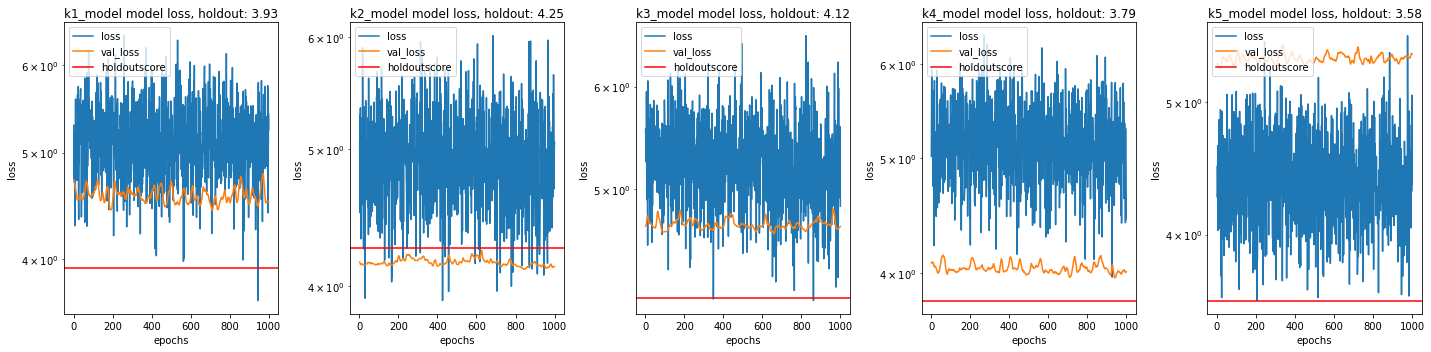

In [88]:
models, histories, hscores = kfm.model_kfold(train_x, train_y, holdout=[holdout_x,holdout_y], model='v1', num_folds=5, batch_size=None, steps_per_epoch=1, loss_function='mean_absolute_error', optimizer='adam', max_epochs=1000, verbosity=1, workers=6, use_multiprocessing=True, continue_training=True, save_models_afte_training=True, plot_results=True, reshuffle=False, random_state=42, path=None)

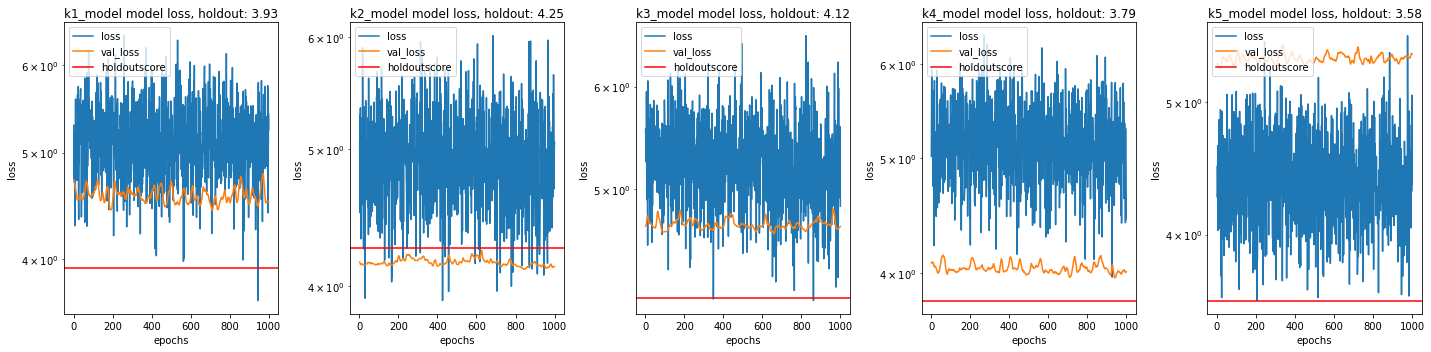

In [89]:
kfm.graph(histories, tight_layout=True, holdoutscores=hscores)

In [ ]:
# save model
#model.save('./_model_deep/model.h5')

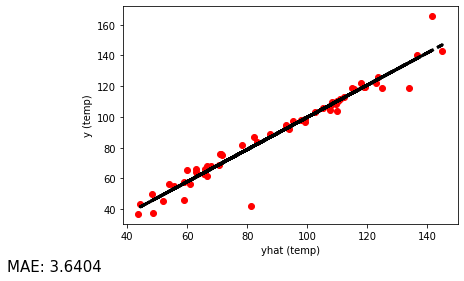

In [90]:
yhat1 = models['k1_model'].predict(holdout_x)
yhat2 = models['k2_model'].predict(holdout_x)
yhat3 = models['k3_model'].predict(holdout_x)
yhat4 = models['k4_model'].predict(holdout_x)
yhat5 = models['k5_model'].predict(holdout_x)

yhat = (yhat1+yhat2+yhat3+yhat4+yhat5)/5

MAE = mean_absolute_error(yhat, holdout_y)

# poly1d_fn is a function which takes in yhat values and returns an estimate for y
coef = np.polyfit(yhat.flat, holdout_y,1)
poly1d_fn = np.poly1d(coef)

# correlation y/yhat
plt.scatter(yhat, holdout_y, color='Red')
plt.plot(yhat , poly1d_fn(yhat), '--k', linewidth=3,)
plt.xlabel("yhat (temp)")
plt.ylabel("y (temp)")
plt.text(0, 0, r'MAE: {:.4f}'.format(MAE), fontsize=15)
plt.show()

## preparing submission dataframe

In [ ]:
# creating submission dataframe
""""df_target = df_target.fillna(0)
df_target['TrueTemp'] = models['k4_model'].predict(sc.transform(df_target.loc[:, df_target.columns != 'TrueTemp']))
df_to_send = df_target.reset_index()
df_to_send[['UWI', 'TrueTemp']].to_csv('predictions.csv', index=True)

In [ ]:
# creating submission dataframe
""""df_target = df_target.fillna(0)

df_target['k1'] = models['k1_model'].predict(sc.transform(df_target.loc[:, df_target.columns != 'TrueTemp']))
df_target['k2'] = models['k2_model'].predict(sc.transform(df_target.loc[:, df_target.columns != 'TrueTemp']))
df_target['k3'] = models['k3_model'].predict(sc.transform(df_target.loc[:, df_target.columns != 'TrueTemp']))
df_target['k4'] = models['k4_model'].predict(sc.transform(df_target.loc[:, df_target.columns != 'TrueTemp']))
df_target['k5'] = models['k5_model'].predict(sc.transform(df_target.loc[:, df_target.columns != 'TrueTemp']))
df_target['TrueTemp'] = (df_target['k1']+df_target['k2']+df_target['k3']+df_target['k3']+df_target['k5'])/5
df_to_send = df_target.reset_index()
df_to_send[['UWI', 'TrueTemp']].to_csv('predictions.csv', index=True)

In [ ]:
# ziping submission
import zipfile
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")

## mapping results

In [61]:
df_plot = pd.DataFrame(df_ohe)
df_plot = df_plot.fillna(0)
df_plot['Prediction'] = models['k4_model'].predict(sc.transform(df_plot.loc[:, df_plot.columns != 'TrueTemp']))
df_plot['TrueTemp'] = df_ohe['TrueTemp']
df_plot['TrueTemp'] = df_plot['TrueTemp'].fillna(df_plot['Prediction'])
df_plot['thermal_grad'] = ((df_plot['TrueTemp']-15.5)+273.15)/((df_plot['BHT_md_ft'])/3.28) # K/m

In [72]:
test = pd.DataFrame(well_data_Softypo_ft)

In [75]:
test['thermal_cond'] = 1.15 + 2.59*(test['RHO']*1000) + 1.08*test['PHIT'] - 0.28*(test['RHO']*1000*5) - 0.0083*((test['BHT']-15.5)+273.15) - 1.66*test['VSHALE']
test['thermal_diff'] = 1.59 + 0.57*(test['RHO']*1000) - 0.70*test['PHIT'] - 0.113*(test['RHO']*1000*5) - 0.0043*((test['BHT']-15.5)+273.15) - 0.45*test['VSHALE']
# test['heat_capacity'] = 584 - 194.4*(test['RHO']*1000) + 1250*test['PHIT'] + 10.93*test['U'] + 4.03*((test['BHT']-15.5)+273.15) - 435.9*test['VSHALE']
test['spec_heat'] = test['thermal_cond']/((test['RHO']*1000)*test['thermal_diff'])
#test['heat_flux'] = test['thermal_cond']*(test['thermal_grad']) # W/M2

In [76]:
df_plot = df_plot.loc[:,['TrueTemp', 'thermal_grad']]
df_plot['SurfaceLatitude_NAD83'] = df['SurfaceLatitude_NAD83']
df_plot['SurfaceLongitude_NAD83'] = df['SurfaceLongitude_NAD83']
df_plot['Field'] = df['Field']

In [80]:
df_plot['thermal_cond'] = well_data_Softypo_ft['thermal_cond']
df_plot['thermal_diff'] = well_data_Softypo_ft['thermal_diff']
df_plot['spec_heat'] = well_data_Softypo_ft['spec_heat']

df_plot['heat_flux'] = df_plot['thermal_cond']*(df_plot['thermal_grad']) # W/M2
df_plot['heat_flux'] = df_plot['heat_flux'].fillna(0)

In [93]:
token = "pk.eyJ1Ijoic29mdHlwbyIsImEiOiJja3B5bDFxdTQwZWdvMnZxc3BicGg0bDh5In0.yySzE4jZALgo-JAHdS0zrA" # you will need your own token

import plotly.express as px

fig = px.scatter_mapbox(df_plot.loc[df_plot['Field'] == 'Eaglebine'], lat="SurfaceLatitude_NAD83", lon="SurfaceLongitude_NAD83", color="TrueTemp", size="heat_flux",
                  color_continuous_scale=px.colors.sequential.solar, size_max=30, zoom=5, width=1000, height=500)
fig.update_layout(mapbox_style="light", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [92]:
fig = px.scatter_mapbox(df_plot.loc[df_plot['Field'] == 'Duvernay'], lat="SurfaceLatitude_NAD83", lon="SurfaceLongitude_NAD83", color="TrueTemp", size="heat_flux",
                  color_continuous_scale=px.colors.sequential.solar, size_max=30, zoom=5, width=1000, height=500)
fig.update_layout(mapbox_style="light", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()